I recently came accross this blog article ["Cities with Nice Weather"](https://jdonland.github.io/city_temperatures/index.html) by ***Jesse Onland***.

He explains his approach on how to find the best cities for him to live in, in terms of climate.

What he's looking for is a city with an average temperature over a year close to that of Toronto, and a variance/range in temperature as small as possible.

His analysis is interesting, well written and organized, but the data he used is far from being exhaustive.

Indeed, the [list he got from Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) only shows temperature data for major cities, so he might be missing his dream city without knowing it...

Also, the list provides temperature data only, no information aboud wind speed and relative humidity, which are two important factors influcencing the perceived temperature.

Let's try the same approach with an other dataset, and see if we can draw the same conclusions.

Some imports for later:

In [1]:
%matplotlib inline
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry_convert as pc
from adjustText import adjust_text
from geopandas import GeoDataFrame
from meteostat import Normals, Point
from tqdm.notebook import tqdm

Point.radius = 55_000  # Maximum radius for nearby stations in meters
plt.rcParams["figure.facecolor"] = (1.0, 1.0, 1.0, 1)
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["legend.fontsize"] = "x-large"
plt.rcParams["axes.titlesize"] = "x-large"
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] = "x-large"
plt.rcParams["ytick.labelsize"] = "x-large"
pd.set_option("display.max_rows", None)

## Get Data for Cities

First, we start with getting a list of cities with the name, country, population and coordinates since we're gonna need latitude and longitude to retrieve historical weather data later on.

This kind of data is fortunately quite easy to find, and more importantly, free.

`dataset_1` is taken from [opendatasoft](https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name). It contains information for 140,000 cities in the world.

`dataset_2` is from the [World Cities Database](https://simplemaps.com/data/world-cities), contains the same kind of data than `dataset_1`.

In [2]:
dataset_1 = pd.read_csv(r"./data/geonames-all-cities-with-a-population-1000.csv", sep=";", na_filter=False)
dataset_2 = pd.read_csv(r"./data/simplemaps_worldcities_basicv1.75.csv", sep=",", na_filter=False)
# We need to set na_filter=False since pandas will convert country code "NA" for Namibia as NaN...

In [3]:
dataset_1.head()

,Geoname ID,Name,ASCII Name,Alternate Names,Feature Class,Feature Code,Country Code,Country name EN,Country Code 2,Admin1 Code,Admin2 Code,Admin3 Code,Admin4 Code,population,Elevation,DIgital Elevation Model,Timezone,Modification date,LABEL EN,Coordinates
0,8396129,Sanjiang,Sanjiang,"Sanjiang,Sanjiang Jiedao,Sanjiang Qu,san jiang...",P,PPLA3,CN,China,,01,3402,,,0,,14,Asia/Shanghai,2021-09-19,China,"31.34813,118.36132"
1,8405692,Xinmin,Xinmin,"Xinmin,Xinmin Zhen,xin min,xin min zhen,新民,新民镇",P,PPLA4,CN,China,,33,8739734,,,28033,,402,Asia/Shanghai,2022-04-12,China,"30.39759,107.3895"
2,8416824,Jindaoxia,Jindaoxia,"Jindaoxia,Jindaoxia Zhen,jin dao xia,jin dao x...",P,PPLA4,CN,China,,33,8739734,,,13752,,323,Asia/Shanghai,2022-04-01,China,"30.00528,106.65187"
3,8420197,Jianlong,Jianlong,"Jianlong,Jianlong Xiang,jian long,jian long xi...",P,PPLA4,CN,China,,33,8739734,,,18151,,276,Asia/Shanghai,2022-04-01,China,"29.3586,106.18522"
4,8505210,Jianhua,Jianhua,"Bukui,Bukui Jiedao,Jianhua,Jianhua Qu,bo kui,b...",P,PPLA3,CN,China,,08,2302,,,0,,146,Asia/Shanghai,2022-03-12,China,"47.35773,123.95977"


Would be nice to split the `Coordinates` column:

In [4]:
dataset_1["Coordinates"] = dataset_1["Coordinates"].astype("string")
dataset_1[["lat", "lng"]] = dataset_1["Coordinates"].str.split(pat=",", n=1, expand=True)
dataset_1["lat"] = dataset_1["lat"].astype(float)
dataset_1["lng"] = dataset_1["lng"].astype(float)

We drop useless data:

In [5]:
dataset_1.drop(
    columns=[
        "Geoname ID",
        "Name",
        "Alternate Names",
        "Feature Class",
        "Feature Code",
        "Country Code 2",
        "Admin1 Code",
        "Admin2 Code",
        "Admin3 Code",
        "Admin4 Code",
        "Elevation",
        "DIgital Elevation Model",
        "Timezone",
        "LABEL EN",
        "Modification date",
        "Coordinates",
    ],
    inplace=True,
)

Some entries don't have a country name, we remove them:

In [6]:
dataset_1.query("`Country name EN` != ''", inplace=True)

Done with `dataset_1`! Let's clean the second one:

In [7]:
dataset_2.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000,1076532519


Again, we drop useless columns:

In [8]:
dataset_2.drop(columns=["city", "iso2", "iso3", "admin_name", "capital", "id"], inplace=True)

Some cities lack population data, we remove them:

In [9]:
dataset_2 = dataset_2[dataset_2["population"].str.isnumeric()]
dataset_2["population"] = dataset_2["population"].astype(int)

Looks like `dataset_1` is more exhaustive than `dataset_2`:

In [10]:
print(dataset_1.shape, dataset_2.shape)

(139571, 6) (42143, 5)


Let's check the data for a small city in UK:

In [11]:
dataset_1.query("`Country Code` == 'GB' and `ASCII Name` == 'Portsmouth'")

,ASCII Name,Country Code,Country name EN,population,lat,lng
66901,Portsmouth,GB,United Kingdom,194150,50.79899,-1.09125


In [12]:
dataset_2.query("`country` == 'United Kingdom' and city_ascii == 'Portsmouth'")

,city_ascii,lat,lng,country,population
2407,Portsmouth,50.8058,-1.0872,United Kingdom,248440


Not the same figures but seems pretty close to reality.

What about Tokyo:

In [13]:
dataset_1.query("`Country Code` == 'JP' and `ASCII Name` == 'Tokyo'")

,ASCII Name,Country Code,Country name EN,population,lat,lng
33145,Tokyo,JP,Japan,8336599,35.6895,139.69171


In [14]:
dataset_2.query("`country` == 'Japan' and city_ascii == 'Tokyo'")

,city_ascii,lat,lng,country,population
0,Tokyo,35.6839,139.7744,Japan,39105000


This time the difference is not negligible, there's a huge difference in terms of population size.

Looks like the `dataset_1` considers the 23 wards that made up the boundaries of the historic city of Tokyo, while `dataset_2` considers the greater Tokyo metropolitan area, which is spread over 3 prefectures...

We should notice the same issue with Manila, capital city of the Philippines:

In [15]:
dataset_1.query("`Country Code` == 'PH' and `ASCII Name` == 'Manila'")

,ASCII Name,Country Code,Country name EN,population,lat,lng
16765,Manila,PH,Philippines,1600000,14.6042,120.9822


In [16]:
dataset_2.query("`country` == 'Philippines' and city_ascii == 'Manila'")

,city_ascii,lat,lng,country,population
3,Manila,14.6,120.9833,Philippines,23971000


Yes, same issue: `dataset_1` considers the Manila city, while `dataset_2` gives data for the larger urban area of Metro Manila.

This explains why `dataset_2` was smaller, it merges cities of large urban areas.

In [17]:
dataset_1.query("`Country Code` == 'SG' and `ASCII Name` == 'Singapore'")

,ASCII Name,Country Code,Country name EN,population,lat,lng
9440,Singapore,SG,Singapore,3547809,1.28967,103.85007


In [18]:
dataset_2.query("`country` == 'Singapore'")

,city_ascii,lat,lng,country,population
135,Singapore,1.3,103.8,Singapore,5271000


Both dataset seem outdated since Singapore current population is 6M, for both the country and the city.

Some data visualization would help to see if some cities/countries/continents are missing:

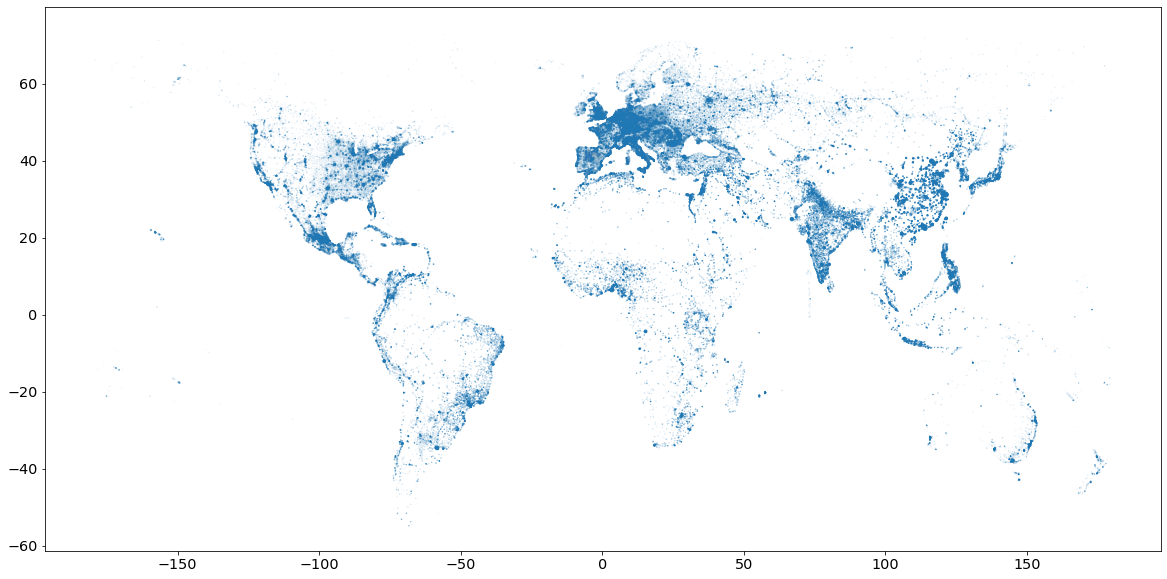

In [19]:
plt.scatter(x=dataset_1["lng"], y=dataset_1["lat"], s=dataset_1["population"] / 1e6)
plt.show()

People sure like living near the sea!

Same plot with `dataset_2` this time:

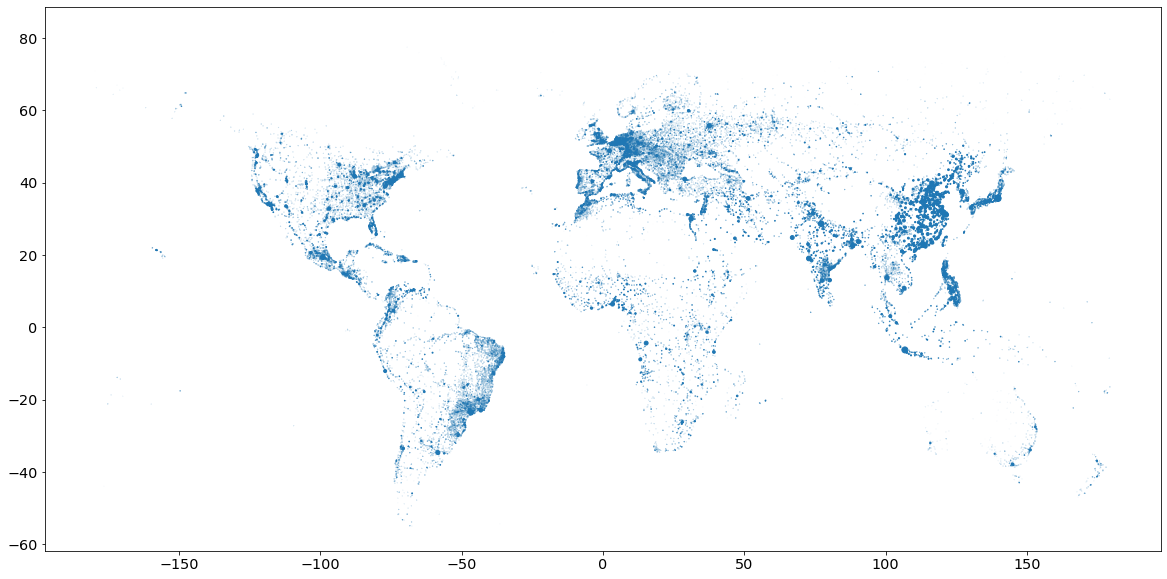

In [20]:
plt.scatter(x=dataset_2["lng"], y=dataset_2["lat"], s=dataset_2["population"] / 1e6)
plt.show()

Since both dataset seem accurate enouth, from now on we'll just keep the first dataset.

In [21]:
df = dataset_1
print(df.shape)
df.head()

(139571, 6)


,ASCII Name,Country Code,Country name EN,population,lat,lng
0,Sanjiang,CN,China,0,31.34813,118.36132
1,Xinmin,CN,China,28033,30.39759,107.38950
2,Jindaoxia,CN,China,13752,30.00528,106.65187
3,Jianlong,CN,China,18151,29.35860,106.18522
4,Jianhua,CN,China,0,47.35773,123.95977


We add a column for the continent code, might be useful later:

In [22]:
df["Country Code"] = df["Country Code"].astype("string")
df.query("`Country Code` != 'TL'", inplace=True)  # Remove Timor-Leste, not supported by pycountry
df.query("`Country Code` != 'EH'", inplace=True)  # Remove Western Sahara, not supported by pycountry
df["Continent Code"] = df.apply(lambda row: pc.country_alpha2_to_continent_code(row["Country Code"]), axis=1)

Number of cities per continent:

In [23]:
print(df.shape)
df["Continent Code"].value_counts()

(139552, 7)


EU    69029
NA    29755
AS    24765
SA     6701
AF     4889
OC     4413
Name: Continent Code, dtype: int64

## Get Historial Weather Data

We now need some historical weather data.

As explained earlier, we can't use [this list](https://en.wikipedia.org/wiki/List_of_cities_by_average_temperature) since it only contains data for "big" cities.

We need historical weather data of the last decade for all the cities shortlisted.

Only monthly statistics are needed since temperatures don't change significantly within a month. We'll compute the variance in temperature of a city only from the statistical monthly weather data.

[OpenWeather](https://openweathermap.org/) provides an API with [statistical monthly weather data](https://openweathermap.org/api/statistics-api#month) (temp, humidity, wind, etc.) for any month of the entire year, but it's way too expensive for us.

For now, we'll use [Meteostat](https://dev.meteostat.net/), an open platform which provides free access to historical weather and climate data. Unfortunately, it lacks information about wind speed or humidity.

Getting weather data for Tokyo is straightforward:

In [24]:
tokyo = Point(lat=35.6839, lon=139.7744)
data = Normals(tokyo, 1991, 2020).fetch()
data

,tavg,tmin,tmax,prcp,wspd,pres,tsun
month,,,,,,,
1,6.3,2.6,10.0,59.8,NaN,1015.9,NaN
2,7.0,3.1,10.8,56.6,NaN,1015.9,NaN
3,10.0,5.9,14.0,116.6,NaN,1015.1,NaN
4,14.8,10.7,19.0,134.1,NaN,1013.9,NaN
5,19.6,15.7,23.5,139.9,NaN,1011.9,NaN
6,22.8,19.5,26.0,168.0,NaN,1009.0,NaN
7,26.7,23.4,30.0,156.5,NaN,1008.6,NaN
8,28.1,24.7,31.5,154.7,NaN,1010.2,NaN
9,24.4,21.2,27.6,222.4,NaN,1013.0,NaN


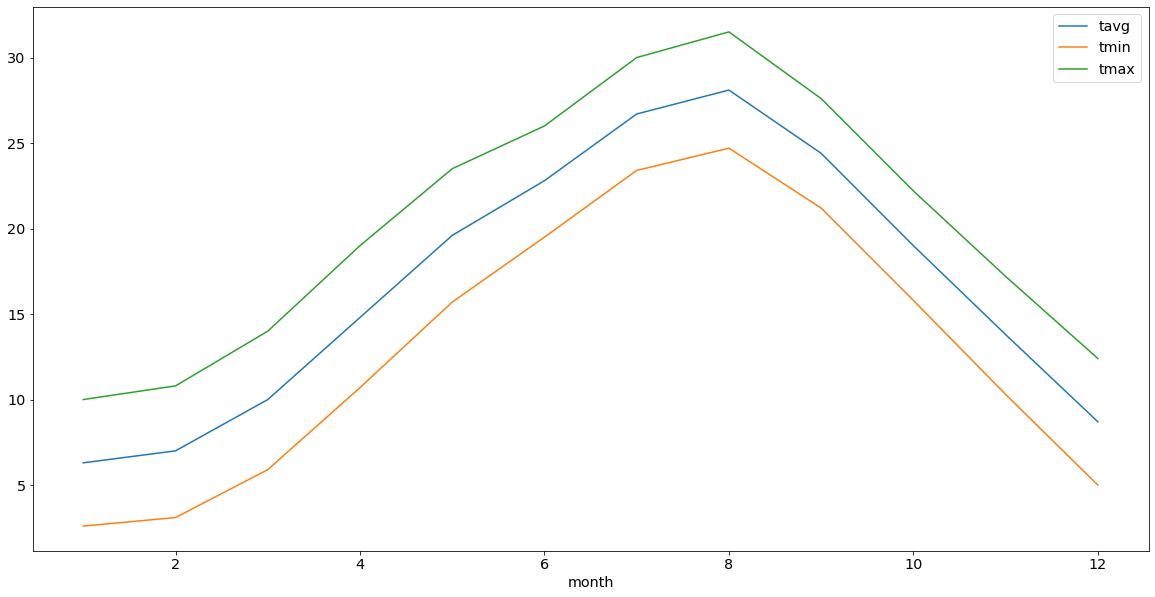

In [25]:
data.plot(y=["tavg", "tmin", "tmax"])
plt.show()

Pretty big temperature variations over the year for Tokyo!

Having lived there for a few weeks, the `tmax` data is closer to ~~the~~ my perceived temperature than the `tavg`.

We code a simple function to get weather data for a specific location:

In [26]:
def get_mean_std_temperature_for_loc(lat: float, lon: float):
    pt = Point(lat=lat, lon=lon)
    try:
        with warnings.catch_warnings():  # disable some meteostat warnings
            warnings.simplefilter("ignore")
            data = Normals(pt, 1991, 2020).fetch()
    except pd.errors.ParserError:  # escape some meteostat bugs
        return np.nan, np.nan, np.nan, np.nan
    mean_ = data["tmax"].mean()
    std_ = data["tmax"].std()
    tmax_ = data["tmax"].max()
    range_ = data["tmax"].max() - data["tmax"].min()
    return mean_, std_, tmax_, range_

Gathering weather data for 140,000 cities takes some time. We keep the biggest cities:

In [27]:
dataset_1.query("population >= 100000", inplace=True)
dataset_2.query("population >= 100000", inplace=True)

We iterate over cities in the dataframe and get weather data. Not the most efficient way to do it but it works...:

In [28]:
Tmean = []
Tstd = []
Tmax = []
Trange = []
for row in tqdm(df.itertuples(), total=df.shape[0]):
    mean_, std_, tmax_, range_ = get_mean_std_temperature_for_loc(row.lat, row.lng)
    Tmean.append(mean_)
    Tstd.append(std_)
    Tmax.append(tmax_)
    Trange.append(range_)
df["Tmean"] = Tmean
df["Tstd"] = Tstd
df["Tmax"] = Tmax
df["Trange"] = Trange

  0%|          | 0/4684 [00:00<?, ?it/s]

Some cities don't have any weather data at all, we drop them:

In [29]:
df.dropna(subset=["Tmean", "Tstd", "Tmax"], inplace=True)

## Summmary Statistics

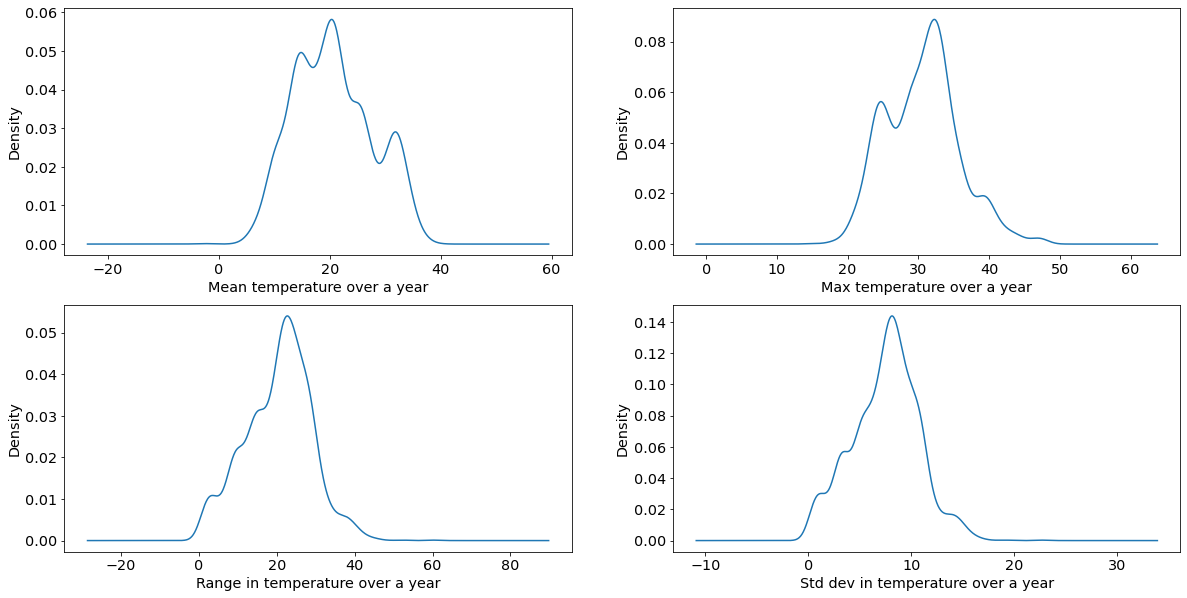

In [30]:
fig, axes = plt.subplots(2, 2)

df[["Tmean"]].plot.kde(ax=axes[0, 0])
axes[0, 0].set_xlabel("Mean temperature over a year")
axes[0, 0].get_legend().remove()

df[["Tmax"]].plot.kde(ax=axes[0, 1])
axes[0, 1].set_xlabel("Max temperature over a year")
axes[0, 1].get_legend().remove()

df[["Tstd"]].plot.kde(ax=axes[1, 1])
axes[1, 1].set_xlabel("Std dev in temperature over a year")
axes[1, 1].get_legend().remove()

df[["Trange"]].plot.kde(ax=axes[1, 0])
axes[1, 0].set_xlabel("Range in temperature over a year")
axes[1, 0].get_legend().remove()

plt.show()

Out of curiosity, get the extreme values in temperature:

In [31]:
df.query("Tmean == Tmean.max() or Tmean == Tmean.min()")

,ASCII Name,Country Code,Country name EN,population,lat,lng,Continent Code,Tmean,Tstd,Tmax,Trange
37323,Mecca,SA,Saudi Arabia,1323624,21.42664,39.82563,AS,38.683333,4.705864,43.9,12.6
49692,Yakutsk,RU,Russian Federation,235600,62.03389,129.73306,EU,-2.883333,22.694887,25.8,60.2


Cities with the most stable/unstable temperatures over a year:

In [32]:
df.query("Tstd == Tstd.min() or Tstd == Tstd.max()").sort_values(by=["Tstd"])

,ASCII Name,Country Code,Country name EN,population,lat,lng,Continent Code,Tmean,Tstd,Tmax,Trange
122628,Jayapura,ID,Indonesia,134895,-2.53371,140.71813,AS,32.241667,0.317543,32.8,1.2
49692,Yakutsk,RU,Russian Federation,235600,62.03389,129.73306,EU,-2.883333,22.694887,25.8,60.2


Yakutsk seems to be a lovely city to live in...

Get some cities to plot later:

In [33]:
cities_to_plot = [
    df.query("`ASCII Name` == 'Reykjavik' and `Country name EN` == 'Iceland'"),
    df.query("`ASCII Name` == 'Yakutsk' and `Country name EN` == 'Russian Federation'"),
    df.query("`ASCII Name` == 'Edinburgh' and `Country name EN` == 'United Kingdom'"),
    df.query("`ASCII Name` == 'Paris' and `Country name EN` == 'France'"),
    df.query("`ASCII Name` == 'Oslo' and `Country name EN` == 'Norway'"),
    df.query("`ASCII Name` == 'Stockholm' and `Country name EN` == 'Sweden'"),
    df.query("`ASCII Name` == 'Helsinki' and `Country name EN` == 'Finland'"),
    df.query("`ASCII Name` == 'Tokyo' and `Country name EN` == 'Japan'"),
    df.query("`ASCII Name` == 'Toronto' and `Country name EN` == 'Canada'"),
    df.query("`ASCII Name` == 'Singapore' and `Country name EN` == 'Singapore'"),
]
assert all(not city.empty for city in cities_to_plot)

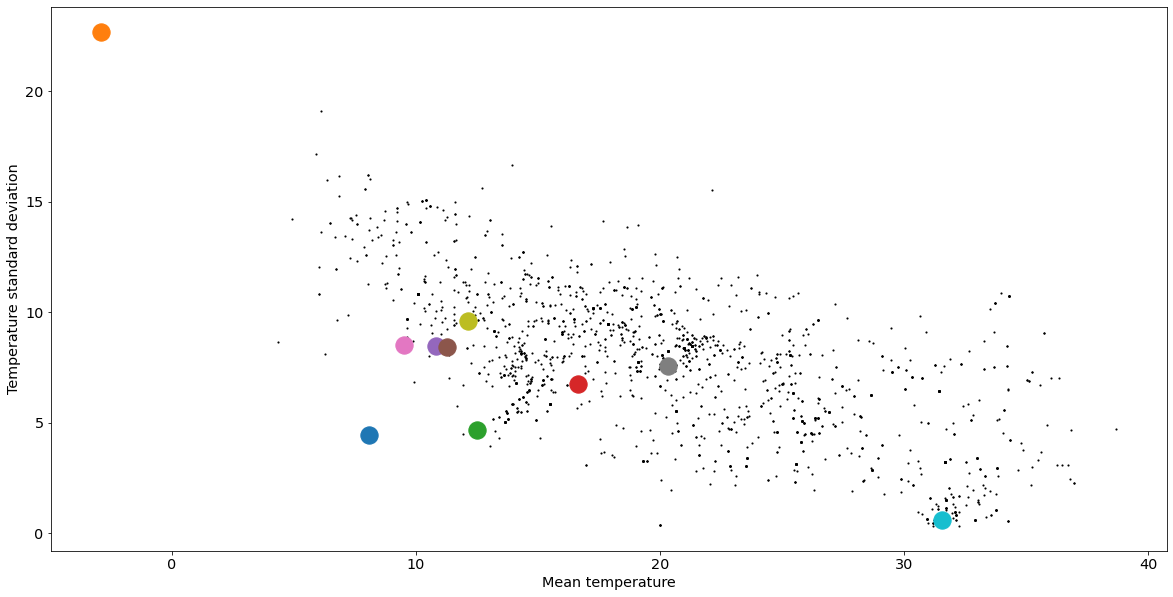

In [34]:
plt.scatter(df["Tmean"], df["Tstd"], s=5, c="k", marker=".")
plt.xlabel("Mean temperature")
plt.ylabel("Temperature standard deviation")
for city in cities_to_plot:
    plt.scatter(
        city["Tmean"].iloc[0],
        city["Tstd"].iloc[0],
        s=300,
        label=f'{city["ASCII Name"].iloc[0]} ({city["Country Code"].iloc[0]})',
    )
plt.show()

Nice inverse correlation!

We plot the same data on a map:

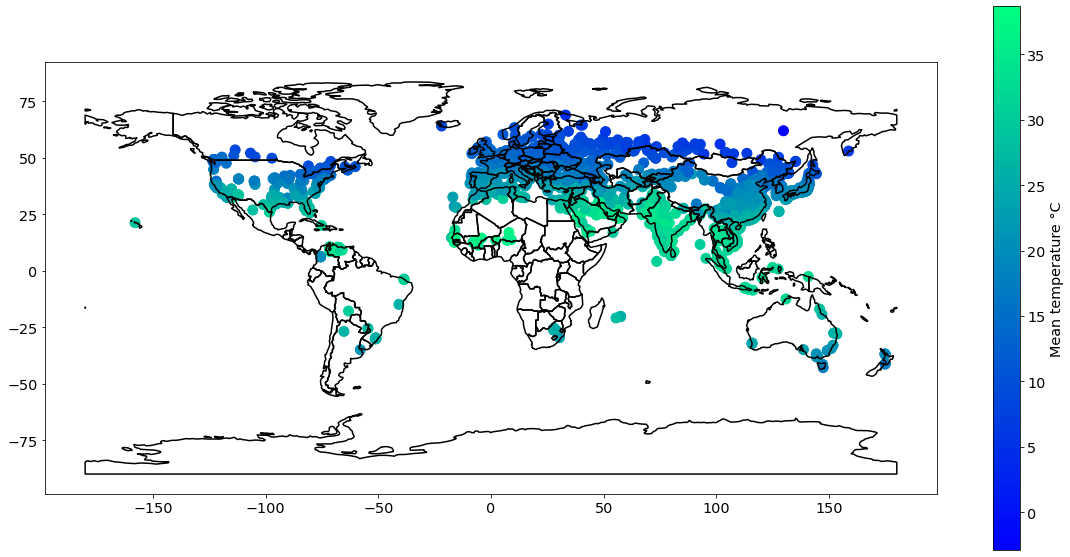

In [35]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = world.boundary.plot(edgecolor="black")
sc = plt.scatter(x=df["lng"], y=df["lat"], c=df["Tmean"], s=100, cmap="winter")
plt.colorbar(sc, label="Mean temperature °C")
plt.show()

Seems like many cities in Africa and South America disappeared for lack of data.

## So Which Cities Are the "Best"?

*Disclaimer: everything below is based only on my personal preferences...*

Set some threshold to remove cities with warm weather:

In [36]:
df_backup = df.copy()
df.query("Tmean <= 17 and Tmax <= 30 and Tstd <= 10 and Trange <= 14", inplace=True)

Most shortlisted cities are in Europe:

In [37]:
print(df.shape)
print(df.groupby(["Continent Code"])["Country name EN"].value_counts())

(37, 11)
Continent Code  Country name EN
EU              United Kingdom     28
                Ireland             2
                France              1
                Iceland             1
NA              Canada              3
OC              New Zealand         2
Name: Country name EN, dtype: int64


Canada shortlisted cities were under the [2021 heat wave](https://en.wikipedia.org/wiki/2021_Western_North_America_heat_wave). No thanks.

In [38]:
df_europe = df.query("`Continent Code` == 'EU'")
df_nz = df.query("`Continent Code` == 'OC'")

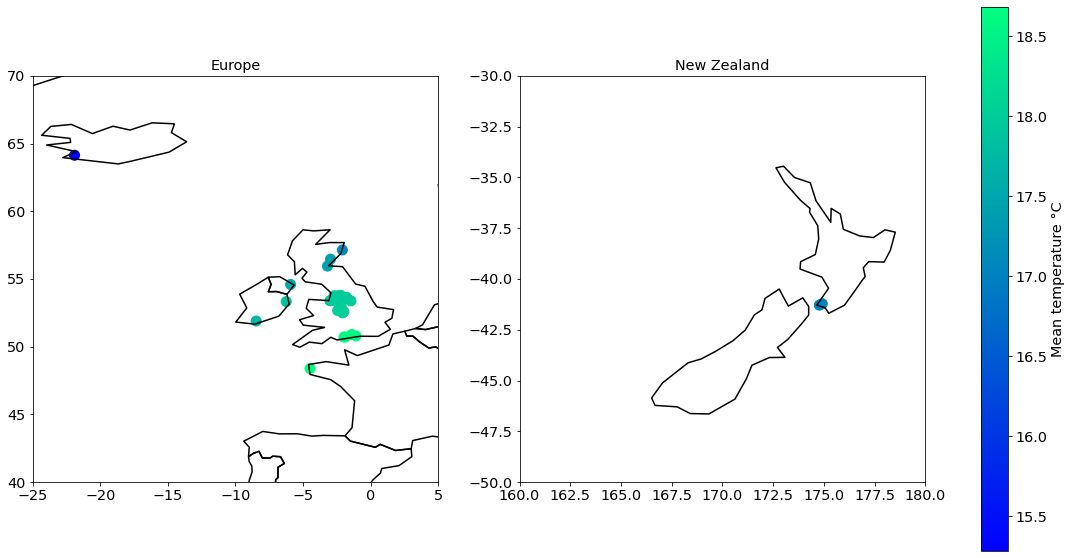

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
world.boundary.plot(ax=ax1, edgecolor="black")
world.boundary.plot(ax=ax2, edgecolor="black")
sc1 = ax1.scatter(x=df_europe["lng"], y=df_europe["lat"], c=df_europe["Tmean"], s=100, marker="o", cmap="winter")
sc2 = ax2.scatter(x=df_nz["lng"], y=df_nz["lat"], c=df_nz["Tmean"], s=100, marker="o", cmap="winter")
ax1.set_xlim(-25, 5)
ax1.set_ylim(40, 70)
ax2.set_xlim(160, 180)
ax2.set_ylim(-50, -30)
cbar = fig.colorbar(sc2, ax=[ax1, ax2])
cbar.set_label("Mean temperature °C")
ax1.set_title("Europe")
ax2.set_title("New Zealand")
plt.show()

I was expecting to see Ireland and Scotland so I'm not surprised.

I however thought some cities from Norway/Sweden/Finland would have been shortlisted. Looks like they have a higher temperature range:

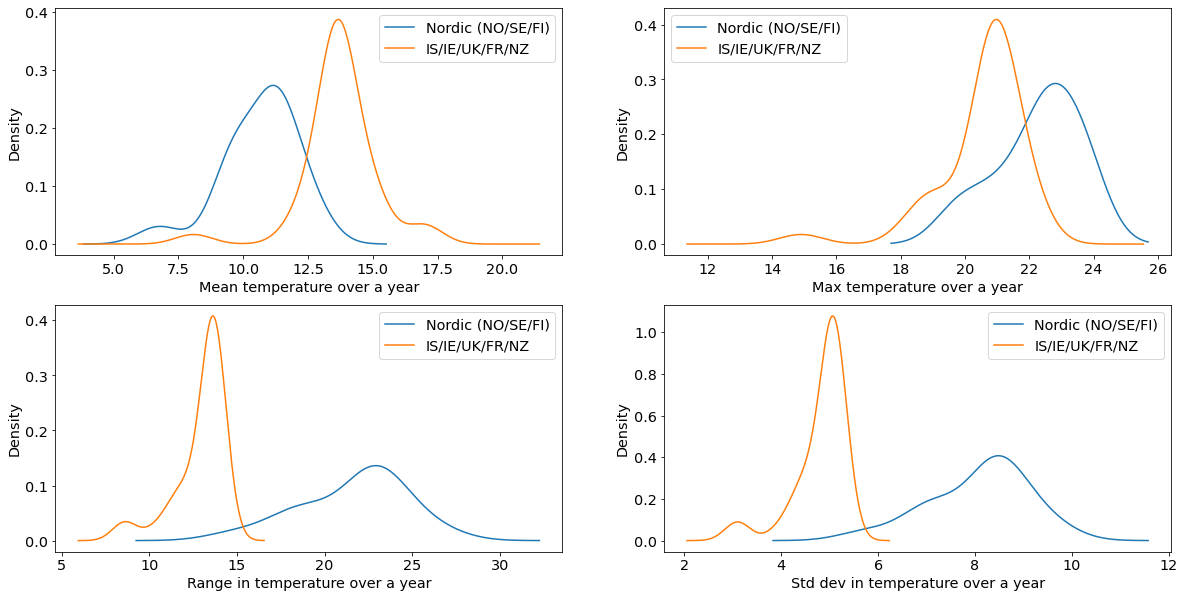

In [40]:
df_shortlisted = pd.concat((df_europe, df_nz))
df_nordic = df_backup.query(
    "`Country name EN` == 'Norway' or `Country name EN` == 'Sweden' or `Country name EN` == 'Finland'"
)

fig, axes = plt.subplots(2, 2)

df_nordic[["Tmean"]].plot.kde(ax=axes[0, 0])
df_shortlisted[["Tmean"]].plot.kde(ax=axes[0, 0])
axes[0, 0].legend(["Nordic (NO/SE/FI)", "IS/IE/UK/FR/NZ"])
axes[0, 0].set_xlabel("Mean temperature over a year")

df_nordic[["Tmax"]].plot.kde(ax=axes[0, 1])
df_shortlisted[["Tmax"]].plot.kde(ax=axes[0, 1])
axes[0, 1].legend(["Nordic (NO/SE/FI)", "IS/IE/UK/FR/NZ"])
axes[0, 1].set_xlabel("Max temperature over a year")

df_nordic[["Tstd"]].plot.kde(ax=axes[1, 1])
df_shortlisted[["Tstd"]].plot.kde(ax=axes[1, 1])
axes[1, 1].legend(["Nordic (NO/SE/FI)", "IS/IE/UK/FR/NZ"])
axes[1, 1].set_xlabel("Std dev in temperature over a year")

df_nordic[["Trange"]].plot.kde(ax=axes[1, 0])
df_shortlisted[["Trange"]].plot.kde(ax=axes[1, 0])
axes[1, 0].legend(["Nordic (NO/SE/FI)", "IS/IE/UK/FR/NZ"])
axes[1, 0].set_xlabel("Range in temperature over a year")

plt.show()

UK/IS/IE seem to have the "best" weather for me.

Left for future work: Include pressure/wind to have the perceived temperature or heat index.